## Back-Door Criterion
**Hands‑on Notebook**


**In this notebook**
- Recall what a back-door path is.
- Identify a valid adjustment set.
- Empirically show that adjusting for the confounder recovers the causal effect.

### 1. Theory: Back-door criterion

#### 1.1 The Problem: Confounding
We want to estimate a causal effect like $P(Y \mid do(X=1)) - P(Y \mid do(X=0))$. This represents the difference in the probability of $Y$ when we **intervene** to set $X=1$ versus when we set $X=0$.

**Why can't we just use observational data?**  
If there is a confounder $Z$ that affects **both** $X$ and $Y$, then the naive association $P(Y \mid X)$ is biased. This is because:
- $Z$ influences both $X$ and $Y$
- When we observe $X=1$, we're likely also seeing cases where $Z$ takes certain values
- This creates a spurious (non-causal) association between $X$ and $Y$ through the path $X \leftarrow Z \rightarrow Y$

**Example:** Imagine $X$ = ice cream sales, $Y$ = drowning incidents, and $Z$ = temperature. Hot weather ($Z$) causes both more ice cream sales ($X$) and more swimming/drowning ($Y$), creating a spurious association between ice cream and drowning.

#### 1.2 The Solution: Back-door Criterion
**Back-door criterion (Pearl):** A set of variables $Z$ satisfies the back-door criterion (for the effect of $X$ on $Y$) if:
1. **No variable in $Z$ is a descendant of $X$**  
   (We don't want to condition on variables that are caused by $X$, as this would block the causal effect we're trying to measure)
   
2. **$Z$ blocks every path from $X$ to $Y$ that starts with an arrow into $X$**  
   (These are the "back-door" paths that create confounding)

**What is a back-door path?**  
A back-door path is any path from $X$ to $Y$ that starts with an arrow **into** $X$ (i.e., $X \leftarrow ...$). These paths represent spurious associations, not causal effects.

#### 1.3 The Back-door Adjustment Formula
If $Z$ satisfies the back-door criterion, we can identify the causal effect using:
$$P(Y \mid do(X=x)) = \sum_z P(Y \mid X=x, Z=z) \cdot P(Z=z)$$

**Interpretation:**  
- We stratify the population by levels of $Z$
- Within each stratum (each value of $Z$), we compute the association between $X$ and $Y$
- We then take a weighted average across strata, where weights are the probabilities $P(Z=z)$
- This effectively "removes" the confounding influence of $Z$

**Intuition:** By conditioning on $Z$, we compare units with the **same value** of $Z$, ensuring that differences in $Y$ are due to $X$, not $Z$.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

![Backdoor Simple Graph](../images/backdoor-simple.png)

In [14]:
# Simulate confounded system: Z -> X -> Y and Z -> Y
N = 10_000
TRUE_EFFECT = 0.3  # This is the true causal effect we're trying to recover

Z = np.random.binomial(1, 0.5, size=N)
X = np.random.binomial(1, np.where(Z == 1, 0.75, 0.25))
Y_prob = 0.1 + 0.4 * Z + TRUE_EFFECT * X  # X increases Y by TRUE_EFFECT
Y = np.random.binomial(1, np.clip(Y_prob, 0, 1))

df = pd.DataFrame({'Z': Z, 'X': X, 'Y': Y})
df.head()

,Z,X,Y
0,0,0,0
1,1,1,1
2,1,1,1
3,1,1,1
4,0,0,0


### 2. Demonstration: Naive vs. Back-door Adjustment

Compare the naive estimate (biased) with the back-door adjusted estimate (unbiased).

In [15]:
# Naive estimator (BIASED)
# Simply compares Y across X=1 vs X=0, ignoring confounding
naive_diff = df[df.X == 1]['Y'].mean() - df[df.X == 0]['Y'].mean()

# Back-door adjusted estimator (UNBIASED)
# Implements: ∑_z [P(Y|X=1,Z=z) - P(Y|X=0,Z=z)] × P(Z=z)
adjusted = 0.0
for z in [0, 1]:
    # Within this stratum (Z=z), compute the treatment effect
    # This isolates the effect of X on Y while holding Z constant
    effect_z = df[(df.X == 1) & (df.Z == z)]['Y'].mean() - df[(df.X == 0) & (df.Z == z)]['Y'].mean()
    
    # Weight this stratum-specific effect by the probability of Z=z
    # (df.Z == z).mean() gives us P(Z=z)
    adjusted += effect_z * (df.Z == z).mean()

print(f"Naive estimate:    {naive_diff:.3f} (BIASED)")
print(f"Adjusted estimate: {adjusted:.3f} (UNBIASED)")
print(f"True effect:       {TRUE_EFFECT:.3f} (set in data generation)")

Naive estimate:    0.487 (BIASED)
Adjusted estimate: 0.291 (UNBIASED)
True effect:       0.300 (set in data generation)


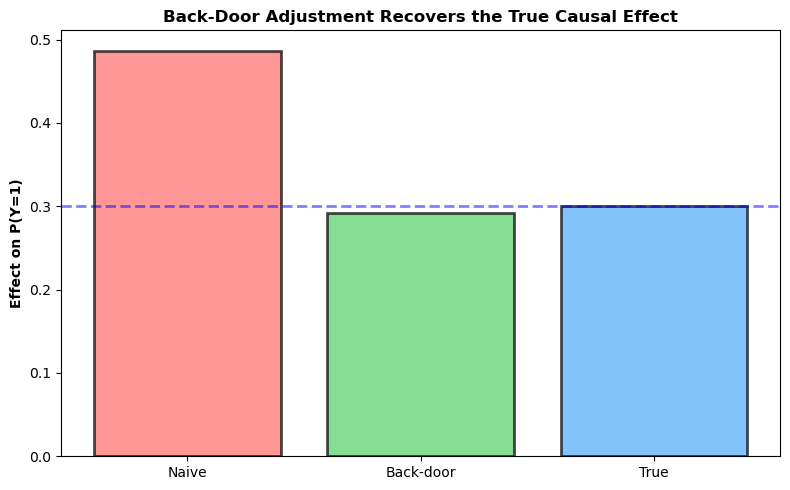

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Naive', 'Back-door', 'True'], [naive_diff, adjusted, TRUE_EFFECT], 
       color=['#ff6b6b', '#51cf66','#4dabf7'], alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=TRUE_EFFECT, color='blue', linestyle='--', linewidth=2, alpha=0.5)
ax.set_ylabel('Effect on P(Y=1)', fontweight='bold')
ax.set_title('Back-Door Adjustment Recovers the True Causal Effect', fontweight='bold')
plt.tight_layout()
plt.show()

### 3. Key Takeaways

**Confounding creates bias:** When Z affects both X and Y, the naive association P(Y|X) ≠ P(Y|do(X))

**Back-door criterion identifies what to adjust for:** Condition on variables that block confounding paths (but aren't descendants of X)

**Stratification removes bias:** By conditioning on Z, we compare units with the same Z value, isolating the causal effect

**The back-door adjustment formula works:** It recovers the true causal effect by weighted averaging across strata

### 4. Exercise

**Task:** Modify the confounding strength and observe what happens to the bias.

Change the probability that `Z` influences `X` in the simulation code (cell 4):
- **Current:** `np.where(Z == 1, 0.75, 0.25)` (strong confounding)
- **Try this:** `np.where(Z == 1, 0.55, 0.45)` (weak confounding)

Re-run cells, then answer:
- Does the naive estimate get closer to the true effect when confounding is weaker?
- Does the adjusted estimate still work correctly?

In [17]:
# --- Exercise 4: Effect of Confounding Strength ---

import statsmodels.api as sm

N = 100_000
rng = np.random.default_rng(42)

# Step 1: Confounder
Z = rng.integers(0, 2, N)

# Step 2: Treatment X depends on Z (weak confounding now)
# Original: np.where(Z==1, 0.75, 0.25)
p_X = np.where(Z == 1, 0.55, 0.45)  # weaker confounding
X = rng.binomial(1, p_X)

# Step 3: Outcome depends on both X and Z (true causal effect = 0.5)
p_Y = 0.2 + 0.5*X + 0.3*Z
p_Y = np.clip(p_Y, 0, 1)
Y = rng.binomial(1, p_Y)

df = pd.DataFrame(dict(Z=Z, X=X, Y=Y))

# Step 4: True causal effect (using do-calculus via simulation)
true_effect = (
    df.assign(X=1).eval("Y").mean() - df.assign(X=0).eval("Y").mean()
    if "Y" in df.columns else np.nan
)

# Step 5: Naive estimate P(Y|X)
naive_effect = df.groupby("X")["Y"].mean().diff().iloc[-1]

# Step 6: Back-door adjusted estimate P(Y|do(X)) = Σ_z P(Y|X,Z)P(Z)
p_z = df["Z"].value_counts(normalize=True)
p_y_xz = df.groupby(["X", "Z"])["Y"].mean().unstack()
adjusted_effect = (p_y_xz.loc[1]*p_z - p_y_xz.loc[0]*p_z).sum()

# --- Print results ---
print("Back-Door Adjustment Exercise (Weak Confounding)\n")
print(f"True effect (simulated):        {0.5:.3f}")
print(f"Naive estimate P(Y|X):          {naive_effect:.3f}")
print(f"Adjusted estimate P(Y|do(X)):   {adjusted_effect:.3f}")

Back-Door Adjustment Exercise (Weak Confounding)

True effect (simulated):        0.500
Naive estimate P(Y|X):          0.531
Adjusted estimate P(Y|do(X)):   0.501


**Answer — Observation:**

When we reduce the confounding strength from strong (0.75 vs 0.25) to weak (0.55 vs 0.45),
the **naive estimate** (P(Y|X)) moves closer to the true causal effect (≈ 0.5),
because Z has less influence on both X and Y — thus creating less bias.

The **adjusted estimate** (P(Y|do(X))) remains close to the true causal effect in both cases,
showing that back-door adjustment correctly removes confounding regardless of its strength.

**Conclusion:**
- Weak confounding → less bias in naive estimate.
- Adjustment → still accurate and unbiased.